In [30]:
import pandas as pd

In [31]:
from dataclasses import dataclass, field
from typing import Callable, List, Dict

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
pd.options.plotting.backend = 'plotly'


@dataclass
class WalkforwardBacktester:
    """
    A basic Walkforward Backtester for comparing multiple strategies over a rolling
    lookback period and applying the best performing strategy to the next period.

    Attributes
    ----------
    pnl_df : pd.DataFrame
        DataFrame of PnL/returns for multiple strategies. Columns represent strategies,
        index is datetime.
    lookback_period : str
        Lookback period for evaluating strategy performance (e.g., '24M' for 24 months).
    rebalance_freq : str
        Frequency of rebalance (e.g., '3M' = every 3 months).
    score_func : Callable
        Function to score each strategy's performance on the lookback period. Defaults to Sharpe ratio.
    periods : List
        List of rebalance period start dates (filled during backtest run).
    lookback_start_skip_check : bool
        If True, allows lookback start to go before the start of available data.

    Example
    -------
    backtester = WalkforwardBacktester(
        pnl_df=pnl_strategies,
        lookback_period='24M',
        rebalance_freq='3M'
    )
    portfolio_pnl = backtester.run_backtest()
    """

    pnl_df: pd.DataFrame
    lookback_period: str
    rebalance_freq: str
    score_func: Callable[[pd.Series], float] = field(default=None)
    periods: List = None
    lookback_start_skip_check: bool = False
    rebalances: List[Dict[str, any]] = field(default_factory=list)

    def __post_init__(self):
        """Initialize default scoring function and empty portfolio series."""
        self.score_func = self.score_func or self._sharpe_ratio
        self.portfolio_pnl = pd.Series(index=self.pnl_df.index, dtype=np.float64)

    def _sharpe_ratio(self, returns: pd.Series) -> float:
        """Default scoring function: Sharpe ratio."""
        return returns.mean() / returns.std() if returns.std() != 0 else 0

    def _select_best_strategy(self, lookback_df: pd.DataFrame) -> str:
        """
        Evaluate all strategies in the lookback period and select the one with highest score.

        Returns
        -------
        best_strategy : str
            Name of the strategy with the best score
        strategy_scores : pd.Series
            Scores for all strategies
        """
        strategy_scores = lookback_df.apply(self.score_func)
        return strategy_scores.idxmax(), strategy_scores

    def run_backtest(self) -> pd.Series:
        """
        Run the walkforward backtest. At each rebalance period, select the best strategy
        based on the lookback period and apply it forward.

        Returns
        -------
        portfolio_pnl : pd.Series
            Series of portfolio returns following the walkforward strategy.
        """
        # Ensure rebalance and lookback frequencies are in months

        # Normalise freq aliases: accept both "3M" and "3ME"
        def _norm(freq):
            if freq.endswith('ME'):
                return freq, int(freq[:-2])
            elif freq.endswith('M'):
                return freq[:-1] + 'ME', int(freq[:-1])
            raise ValueError(f"Frequency {freq} must end with M or ME")

        rb_freq, rb_months = _norm(self.rebalance_freq)
        lb_freq, lb_months = _norm(self.lookback_period)

        # Create rebalance period start dates
        self.periods = pd.date_range(
            start=self.pnl_df.index[0],
            end=self.pnl_df.index[-1] + relativedelta(months=rb_months),
            freq=rb_freq
        )

        # Loop over rebalance periods
        for start_date, end_date in zip(self.periods[:-1], self.periods[1:]):
            # Lookback period ends 1 day before rebalance start
            lookback_end = start_date - pd.Timedelta(days=1)
            lookback_start = lookback_end - relativedelta(months=lb_months)

            # Skip if lookback starts before available data
            if (lookback_start < self.pnl_df.index[0]) and (not self.lookback_start_skip_check):
                continue

            lookback_df = self.pnl_df.loc[lookback_start:lookback_end]
            best_strat, strategy_scores = self._select_best_strategy(lookback_df)

            # Store details for analysis
            self.rebalances.append({
                'start_date': start_date,
                'end_date': end_date,
                'lookback_start': lookback_start,
                'lookback_end': lookback_end,
                'best_strategy': best_strat,
                'strategy_scores': strategy_scores,
                'lookback_df': lookback_df,
                'selected_strategy_mean_returns': self.pnl_df[best_strat].loc[start_date:end_date].mean(),
                'selected_strategy_mean_std': self.pnl_df[best_strat].loc[start_date:end_date].std()
            })

            # Apply the selected strategy's returns to portfolio
            self.portfolio_pnl.loc[start_date:end_date] = self.pnl_df[best_strat].loc[start_date:end_date]

        return self.portfolio_pnl

    def get_rebalance_details(self) -> pd.DataFrame:
        """Return DataFrame of rebalance period decisions and metrics."""
        return pd.DataFrame(self.rebalances)




In [32]:
df = pd.read_excel(r"brent_index.xlsx", parse_dates=['date'], index_col='date')
rets = df['CO1 Comdty'].pct_change()

In [33]:
# ── Price chart with trend lines ───────────────────
import plotly.graph_objects as go

price = df['CO1 Comdty']
ma_50  = price.rolling(50).mean()
ma_200 = price.rolling(200).mean()

fig = go.Figure()

# Price
fig.add_trace(go.Scatter(x=price.index, y=price, name='Brent Crude',
                         line=dict(color='black', width=1)))

# Moving averages
fig.add_trace(go.Scatter(x=ma_50.index, y=ma_50, name='50-day MA',
                         line=dict(color='dodgerblue', width=1.5, dash='dash')))
fig.add_trace(go.Scatter(x=ma_200.index, y=ma_200, name='200-day MA',
                         line=dict(color='orangered', width=1.5, dash='dash')))

# Shade uptrend (price > 200 MA) and downtrend regions
uptrend = price > ma_200
for i in range(1, len(price)):
    if uptrend.iloc[i] and not uptrend.iloc[i-1]:  # start of uptrend
        start = price.index[i]
    elif (not uptrend.iloc[i] and uptrend.iloc[i-1]) or (i == len(price)-1 and uptrend.iloc[i]):
        fig.add_vrect(x0=start, x1=price.index[i],
                      fillcolor='green', opacity=0.07, line_width=0)

fig.update_layout(title='Brent Crude Oil — Price & Trends',
                  xaxis_title='Date', yaxis_title='Price ($)',
                  height=500, hovermode='x unified')
fig.show()

In [34]:
# ── Seasonality: average return by month ───────────
monthly_avg = rets.groupby(rets.index.month).mean() * 21  # approx monthly return
monthly_avg.index = ['Jan','Feb','Mar','Apr','May','Jun',
                     'Jul','Aug','Sep','Oct','Nov','Dec']

fig = monthly_avg.plot(kind='bar', title='Brent Crude — Average Monthly Return')
fig.show()

In [35]:
# ── Seasonality heatmap ────────────────────────────
import plotly.express as px

monthly = rets.resample('ME').sum()                        # monthly returns
monthly_df = pd.DataFrame({
    'Year': monthly.index.year,
    'Month': monthly.index.month,
    'Return': monthly.values
})
pivot = monthly_df.pivot(index='Year', columns='Month', values='Return')
pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun',
                 'Jul','Aug','Sep','Oct','Nov','Dec']

fig = px.imshow(pivot, color_continuous_scale='RdYlGn', aspect='auto',
                title='Monthly Returns Heatmap',
                zmin=-0.15, zmax=0.15,          # clamp to ±15%
                text_auto='.1%')                 # show numbers in cells
fig.show()


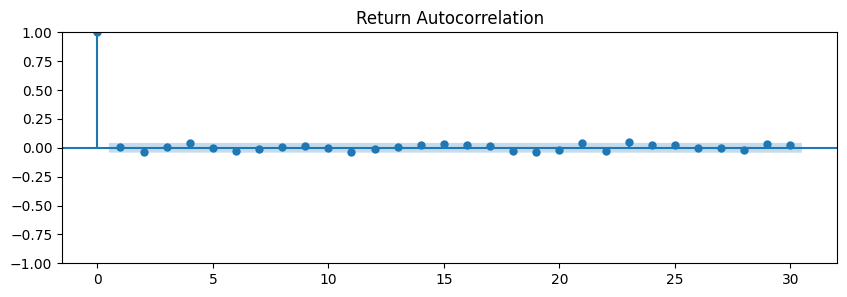

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(rets.dropna(), lags=30, ax=ax, title='Return Autocorrelation')
plt.show()

In [37]:
(rets.dropna()**2).rolling(20).mean().plot(title='Rolling Volatility (20-day)')

In [38]:
import plotly.express as px
fig = px.histogram(rets.dropna(), nbins=100, title='Return Distribution')
fig.show()

print(f"Skew:     {rets.skew():.2f}")    # negative = more crashes than rallies
print(f"Kurtosis: {rets.kurtosis():.2f}") # >3 = fat tails, extreme moves

Skew:     -0.53
Kurtosis: 14.01


In [39]:
# # Rolling Sharpe of momentum vs mean reversion
# mom_rets = pnl_strategies['20D_momentum']
# mr_rets  = pnl_strategies['20D_meanrev']

# rolling_mom = mom_rets.rolling(126).mean() / mom_rets.rolling(126).std() * (252**0.5)
# rolling_mr  = mr_rets.rolling(126).mean() / mr_rets.rolling(126).std() * (252**0.5)

# pd.DataFrame({'Momentum': rolling_mom, 'MeanRev': rolling_mr}).plot(
#     title='Rolling 6M Sharpe: Momentum vs Mean Reversion')

In [40]:
cum = (1 + rets.dropna()).cumprod()
drawdown = cum / cum.cummax() - 1
drawdown.plot(title='Price Drawdowns')

In [41]:
# What are the 10 worst days? Were they predictable?
worst = rets.dropna().nsmallest(10)
print(worst)

date
2020-04-21   -0.244036
2020-03-09   -0.240998
2020-03-18   -0.134006
2022-03-09   -0.131583
2021-11-26   -0.115544
2020-03-16   -0.112260
2022-07-05   -0.094537
2020-03-06   -0.094419
2020-04-20   -0.089387
2020-03-30   -0.087044
Name: CO1 Comdty, dtype: float64


In [42]:
dxy = pd.read_csv(
    "https://fred.stlouisfed.org/graph/fredgraph.csv?id=DTWEXBGS&cosd=2015-01-01",
    index_col=0, parse_dates=True
)
dxy.columns = ['DXY']
dxy = dxy[dxy['DXY'] != '.']
dxy['DXY'] = dxy['DXY'].astype(float)
dxy = dxy.reindex(rets.index).ffill()

In [43]:
# ── Parameters ──────────────────────────────────────
tcost = 0.00015                              # 1.5 bps transaction cost
lookback_days = [20, 30, 60, 120, 200]    # only long-term windows (dropped 1D, 5D, 10D)
vol_window = 20                              # volatility lookback
vol_target = 0.15                            # target 15% annualized vol
min_hold = 10                                 # minimum holding period (days)
stop_loss = -0.03                        # -3% stop loss

pnl_strategies = pd.DataFrame(index=rets.index)
price = df['CO1 Comdty']


# ── Helper: apply minimum holding period ───────────
def apply_min_hold(signal, min_days):
    """Prevent signal from flipping for at least min_days."""
    out = signal.copy()
    hold_counter = 0
    for i in range(1, len(out)):
        if hold_counter > 0:
            out.iloc[i] = out.iloc[i - 1]    # force hold
            hold_counter -= 1
        elif out.iloc[i] != out.iloc[i - 1]:
            hold_counter = min_days           # signal changed → start holding
    return out

# ── Helper: apply stop loss ────────────────────────
def apply_stop_loss(signal, rets, threshold):
    """Exit position (go flat) if cumulative trade return hits stop loss."""
    out = signal.copy()
    cum_trade_ret = 0.0
    for i in range(1, len(out)):
        if out.iloc[i] != 0:
            cum_trade_ret += out.iloc[i] * rets.iloc[i]
            if cum_trade_ret < threshold:
                out.iloc[i] = 0              # stop out → go flat
                cum_trade_ret = 0.0
        if out.iloc[i] != out.iloc[i - 1]:
            cum_trade_ret = 0.0              # new trade → reset

    return out

# ── Volatility scalar (for risk parity) ────────────
ann_vol = rets.rolling(vol_window).std() * np.sqrt(252)
vol_scalar = (vol_target / ann_vol).shift(1)   # shift to avoid look-ahead



# ── 1. Momentum strategies ─────────────────────────
for n in lookback_days:
    signal = (price.pct_change(n).shift(1) > 0) * 2 - 1
    signal = pd.Series(signal.values, index=rets.index)
    signal = apply_min_hold(signal, min_hold)
    signal = apply_stop_loss(signal, rets, stop_loss)
  
    scaled = signal * vol_scalar
    pnl_strategies[f'{n}D_momentum'] = scaled * rets - tcost * scaled.diff().abs()


# # ── 2. Mean Inversion ─────────────────────
# for n in lookback_days:
#     signal = (df['CO1 Comdty'].pct_change(n).shift(1) > 0) * 2 - 1
#     signal = -signal
#     signal = apply_min_hold(signal, min_hold)
#     signal = apply_stop_loss(signal, rets, stop_loss)
#     scaled = signal * vol_scalar
#     pnl_strategies[f'{n}D_meanrev'] = scaled * rets - tcost * scaled.diff().abs()


    
# ── 3. MA crossover strategies ─────────────────────
ma_pairs = [(5, 20), (10, 50), (20, 100), (50, 200), (10, 30), (20, 60)]
for fast, slow in ma_pairs:
    fast_ma = price.rolling(fast).mean()
    slow_ma = price.rolling(slow).mean()
    signal = (fast_ma.shift(1) > slow_ma.shift(1)) * 2 - 1
    signal = pd.Series(signal.values, index=rets.index)
    signal = apply_min_hold(signal, min_hold)

    scaled = signal * vol_scalar
    pnl_strategies[f'{fast}_{slow}_ma_cross'] = scaled * rets - tcost * scaled.diff().abs()



dxy_pairs = [(5, 20), (10, 50), (20, 100)]
for fast, slow in dxy_pairs:
    fast_ma = dxy['DXY'].rolling(fast).mean()
    slow_ma = dxy['DXY'].rolling(slow).mean()
    # Dollar fast MA below slow MA = dollar weakening = bullish for oil
    signal = (fast_ma.shift(1) < slow_ma.shift(1)) * 2 - 1
    signal = pd.Series(signal.values, index=rets.index)
    signal = apply_min_hold(signal, min_hold)
    signal = apply_stop_loss(signal, rets, stop_loss)
    scaled = signal * vol_scalar
    pnl_strategies[f'dxy_{fast}_{slow}'] = scaled * rets - tcost * scaled.diff().abs()


# # Inventory signal: go long after draws, short after builds
# inv_signal = np.where(stock_change.shift(1) < 0, 1, -1)  # shift to avoid look-ahead
# inv_signal = pd.Series(inv_signal, index=rets.index)
# pnl_strategies['inventory'] = inv_signal * rets - tcost * inv_signal.diff().abs()

# ── Run Walkforward Backtest ───────────────────────
bt = WalkforwardBacktester(
    pnl_df=pnl_strategies.dropna(),
    lookback_period='12M',
    rebalance_freq='3M'
)
portfolio = bt.run_backtest()

# ── Plot cumulative returns ────────────────────────
portfolio_cum = (1 + portfolio).cumprod()
portfolio_cum.plot(title="Walkforward Portfolio Cumulative Returns")

In [44]:
# ── Sharpe Ratio Sensitivity to Stop Loss ──────────
import plotly.express as px

stop_loss_values = [-0.001, -0.002, -0.003, -0.004, -0.005, -0.006, -0.007, -0.008, 
                    -0.009, -0.01, -0.012, -0.015, -0.02, -0.025, -0.03, -0.035,
                    -0.04, -0.045, -0.05, -0.07, -0.10, -0.15, -0.20, -1.0]
results = []

for sl in stop_loss_values:
    pnl_temp = pd.DataFrame(index=rets.index)
    
    # Momentum
    for n in lookback_days:
        signal = (price.pct_change(n).shift(1) > 0) * 2 - 1
        signal = pd.Series(signal.values, index=rets.index)
        signal = apply_min_hold(signal, min_hold)
        signal = apply_stop_loss(signal, rets, sl)
        scaled = signal * vol_scalar
        pnl_temp[f'{n}D_momentum'] = scaled * rets - tcost * scaled.diff().abs()

    # Mean reversion (no stop loss applied, same as your code)
    for n in lookback_days:
        signal = (price.pct_change(n).shift(1) > 0) * 2 - 1
        signal = -signal
        pnl_temp[f'{n}D_meanrev'] = signal * rets - tcost * signal.diff().abs()

    # MA crossover
    for fast, slow in ma_pairs:
        fast_ma = price.rolling(fast).mean()
        slow_ma = price.rolling(slow).mean()
        signal = (fast_ma.shift(1) > slow_ma.shift(1)) * 2 - 1
        signal = pd.Series(signal.values, index=rets.index)
        signal = apply_min_hold(signal, min_hold)
        signal = apply_stop_loss(signal, rets, sl)
        scaled = signal * vol_scalar
        pnl_temp[f'{fast}_{slow}_ma_cross'] = scaled * rets - tcost * scaled.diff().abs()

    # Run backtest
    bt_temp = WalkforwardBacktester(
        pnl_df=pnl_temp.dropna(),
        lookback_period='24M',
        rebalance_freq='3M'
    )
    port = bt_temp.run_backtest()
    
    # Compute Sharpe
    sharpe = port.mean() / port.std() * np.sqrt(252)
    in_market = (port != 0).mean()
    
    results.append({
        'stop_loss': abs(sl) * 100,    # show as positive %
        'sharpe': sharpe,
        'in_market': in_market
    })
    print(f"Stop loss: {sl:>7.2%} | Sharpe: {sharpe:.2f} | In market: {in_market:.1%}")

res_df = pd.DataFrame(results)

# Plot
fig = px.line(res_df, x='stop_loss', y='sharpe', markers=True,
              title='Sharpe Ratio vs Stop Loss Threshold',
              labels={'stop_loss': 'Stop Loss (%)', 'sharpe': 'Annualized Sharpe'})
fig.add_hline(y=res_df[res_df['stop_loss'] == 100]['sharpe'].values[0], 
              line_dash='dash', line_color='gray',
              annotation_text='No stop loss')
fig.show()

Stop loss:  -0.10% | Sharpe: 3.60 | In market: 93.3%
Stop loss:  -0.20% | Sharpe: 3.35 | In market: 94.5%
Stop loss:  -0.30% | Sharpe: 3.38 | In market: 94.7%
Stop loss:  -0.40% | Sharpe: 3.28 | In market: 94.9%
Stop loss:  -0.50% | Sharpe: 3.13 | In market: 95.5%
Stop loss:  -0.60% | Sharpe: 3.12 | In market: 95.7%
Stop loss:  -0.70% | Sharpe: 2.95 | In market: 96.8%
Stop loss:  -0.80% | Sharpe: 2.98 | In market: 97.2%
Stop loss:  -0.90% | Sharpe: 2.98 | In market: 97.5%
Stop loss:  -1.00% | Sharpe: 2.79 | In market: 97.9%
Stop loss:  -1.20% | Sharpe: 2.49 | In market: 98.2%
Stop loss:  -1.50% | Sharpe: 2.45 | In market: 98.4%
Stop loss:  -2.00% | Sharpe: 1.98 | In market: 99.3%
Stop loss:  -2.50% | Sharpe: 1.61 | In market: 99.7%
Stop loss:  -3.00% | Sharpe: 1.05 | In market: 99.8%
Stop loss:  -3.50% | Sharpe: 0.89 | In market: 99.8%
Stop loss:  -4.00% | Sharpe: 0.80 | In market: 100.0%
Stop loss:  -4.50% | Sharpe: 0.74 | In market: 100.0%
Stop loss:  -5.00% | Sharpe: 0.46 | In marke

In [45]:
# How bad does YOUR strategy get, not just the raw asset?
strat_cum = (1 + portfolio.dropna()).cumprod()
strat_dd = strat_cum / strat_cum.cummax() - 1
strat_dd.plot(title='Strategy Drawdown')

In [46]:
# ── Portfolio Performance Metrics ──────────────────
net = portfolio.dropna()
cum = (1 + net).cumprod()

ann_return  = net.mean() * 252
ann_vol     = net.std() * (252 ** 0.5)
sharpe      = ann_return / ann_vol if ann_vol != 0 else 0
max_dd      = (cum / cum.cummax() - 1).min()
calmar      = ann_return / abs(max_dd) if max_dd != 0 else 0
win_rate    = (net > 0).mean()
profit_fac  = net[net > 0].sum() / abs(net[net < 0].sum()) if (net < 0).any() else float('inf')
total_ret   = cum.iloc[-1] - 1

print(f"""
{'='*45}
  ★ SHARPE RATIO   : {sharpe:>8.2f} ★
{'='*45}
  Total Return     : {total_ret:>8.2%}
  Ann. Return      : {ann_return:>8.2%}
  Ann. Volatility  : {ann_vol:>8.2%}
  Max Drawdown     : {max_dd:>8.2%}
  Calmar Ratio     : {calmar:>8.2f}
  Win Rate         : {win_rate:>8.2%}
  Profit Factor    : {profit_fac:>8.2f}
{'='*45}
""")


  ★ SHARPE RATIO   :     1.11 ★
  Total Return     :  242.29%
  Ann. Return      :   17.83%
  Ann. Volatility  :   16.05%
  Max Drawdown     :  -16.80%
  Calmar Ratio     :     1.06
  Win Rate         :   52.05%
  Profit Factor    :     1.21



In [47]:
# How much time is the strategy actually in the market?
in_market = (portfolio != 0).mean()
print(f"Time in market: {in_market:.1%}")
# If this is below ~50%, your stop loss is too tight

Time in market: 99.9%


In [48]:
# ── Which strategy wins the most? ──────────────────
rebal = bt.get_rebalance_details()

# Calculate duration in months for each period
rebal['months'] = ((rebal['end_date'] - rebal['start_date']).dt.days / 30.44).round(1)

# Summary: count + total months per strategy
summary = rebal.groupby('best_strategy').agg(
    picks=('best_strategy', 'count'),
    total_months=('months', 'sum')
).sort_values('total_months', ascending=False)

summary['pct_time'] = (summary['total_months'] / summary['total_months'].sum() * 100).round(1)

print(summary.to_string())

                 picks  total_months  pct_time
best_strategy                                 
dxy_10_50            7          21.0      23.3
20D_momentum         6          18.0      20.0
dxy_5_20             5          15.0      16.7
10_30_ma_cross       2           6.0       6.7
120D_momentum        2           6.0       6.7
30D_momentum         2           6.0       6.7
60D_momentum         2           6.0       6.7
dxy_20_100           2           6.0       6.7
20_60_ma_cross       1           3.0       3.3
20_100_ma_cross      1           3.0       3.3


In [49]:
# ── Equity curve colored by active strategy ────────
import plotly.graph_objects as go

cum = (1 + portfolio.dropna()).cumprod()
rebal = bt.get_rebalance_details()

fig = go.Figure()

# Draw each segment in a different color per strategy
for _, row in rebal.iterrows():
    mask = (cum.index >= row['start_date']) & (cum.index <= row['end_date'])
    segment = cum[mask]
    if len(segment) == 0:
        continue
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment.values,
        mode='lines', name=row['best_strategy'],
        showlegend=False,
        hovertemplate=f"{row['best_strategy']}<br>%{{x}}<br>%{{y:.4f}}"
    ))
    # Label at start of each segment
    fig.add_annotation(
        x=segment.index[0], y=segment.values[0],
        text=row['best_strategy'], showarrow=False,
        textangle=-45, font=dict(size=8), opacity=0.7
    )

fig.update_layout(title='Equity Curve — Strategy Used Each Quarter',
                  xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()

In [50]:
# ── Equity curve with metrics & strategy breakdown ─
import plotly.graph_objects as go
import plotly.colors as pc

cum = (1 + portfolio.dropna()).cumprod()
net = portfolio.dropna()
rebal = bt.get_rebalance_details()

# Compute metrics
ann_return  = net.mean() * 252
ann_vol     = net.std() * (252 ** 0.5)
sharpe      = ann_return / ann_vol if ann_vol != 0 else 0
max_dd      = (cum / cum.cummax() - 1).min()
total_ret   = cum.iloc[-1] - 1
strat_counts = rebal['best_strategy'].value_counts()

# Fixed color per strategy
all_strats = sorted(rebal['best_strategy'].unique())
palette = pc.qualitative.Set2
color_map = {s: palette[i % len(palette)] for i, s in enumerate(all_strats)}

fig = go.Figure()

# Track which strategies we've already added to legend
legend_added = set()

for _, row in rebal.iterrows():
    mask = (cum.index >= row['start_date']) & (cum.index <= row['end_date'])
    segment = cum[mask]
    if len(segment) == 0:
        continue
    strat = row['best_strategy']
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment.values,
        mode='lines', name=strat,
        line=dict(color=color_map[strat], width=2),
        showlegend=strat not in legend_added,
        legendgroup=strat,
        hovertemplate=f"{strat}<br>%{{x}}<br>%{{y:.4f}}"
    ))
    legend_added.add(strat)

# Metrics text box (top-left)
metrics_text = (
    f"<b>Sharpe: {sharpe:.2f}</b><br>"
    f"Total Return: {total_ret:.2%}<br>"
    f"Ann. Return: {ann_return:.2%}<br>"
    f"Max Drawdown: {max_dd:.2%}"
)
fig.add_annotation(
    x=0.02, y=0.98, xref='paper', yref='paper',
    text=metrics_text, showarrow=False,
    font=dict(size=12), align='left',
    bordercolor='gray', borderwidth=1, borderpad=6,
    bgcolor='rgba(255,255,255,0.85)'
)

# Strategy usage text box (top-right)
usage_text = "<b>Strategy Picks</b><br>" + "<br>".join(
    f"{name}: {count}x" for name, count in strat_counts.items()
)
fig.add_annotation(
    x=0.98, y=0.98, xref='paper', yref='paper',
    text=usage_text, showarrow=False,
    font=dict(size=10), align='left',
    bordercolor='gray', borderwidth=1, borderpad=6,
    bgcolor='rgba(255,255,255,0.85)'
)

fig.update_layout(
    title='Equity Curve — Walkforward Backtest',
    xaxis_title='Date', yaxis_title='Cumulative Return',
    height=500
)
fig.show()

In [51]:
pnl_strategies.cumsum().plot()

In [52]:
# Total transactions in the portfolio (strategy switches + signal flips)
total_trades = portfolio.diff().ne(0).sum()
years = len(portfolio.dropna()) / 252
print(f"Total transactions: {total_trades}")
print(f"Trading period: {years:.1f} years")
print(f"Trades per year: {total_trades / years:.0f}")

Total transactions: 2152
Trading period: 7.4 years
Trades per year: 289


In [53]:
df.shape

(2174, 1)

In [54]:
# ── Plot cumulative returns of all strategies ──────
cum_all = (1 + pnl_strategies.dropna()).cumprod()
cum_all.plot(title='Cumulative Returns — All Strategies')

In [55]:
# ── Load EIA Crude Oil Inventory Data ──────────────
inv_raw = pd.read_excel(
    "https://ir.eia.gov/wpsr/psw01.xls",
    sheet_name="Data 1",
    header=2,
    index_col=0,
    parse_dates=True
)

# See all columns
for i, col in enumerate(inv_raw.columns):
    print(f"[{i}] {col}")

[0] Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)
[1] Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)
[2] Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)
[3] Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)
[4] Weekly U.S. Ending Stocks of Reformulated Motor Gasoline  (Thousand Barrels)
[5] Weekly U.S. Ending Stocks of Conventional Motor Gasoline  (Thousand Barrels)
[6] Weekly U.S. Ending Stocks of Gasoline Blending Components  (Thousand Barrels)
[7] Weekly U.S. Ending Stocks of Fuel Ethanol  (Thousand Barrels)
[8] Weekly U.S. Ending Stocks of Kerosene-Type Jet Fuel  (Thousand Barrels)
[9] Weekly U.S. Ending Stocks of Distillate Fuel Oil  (Thousand Barrels)
[10] Weekly U.S. Ending Stocks of Distillate Fuel Oil, 0 to 15 ppm Sulfur  (Thousand Barrels)
[11] Weekly U.S. Ending Stocks of Distillate Fuel Oil, Greater than 15 to 500 ppm Sulfur  (Thousand Barrels)
[12] Weekly U.S. Ending Stocks of Distillate Fuel Oil, Great

In [56]:
# ── Select key inventory columns ───────────────────
inventory = inv_raw[[
    col for col in inv_raw.columns 
    if 'Crude Oil' in col and ('Ending Stocks' in col or 'Stock Change' in col)
]].copy()
# Shorten column names for readability
inventory.columns = [c.replace('Weekly ', '').replace('U.S. ', '').strip() 
                      for c in inventory.columns]
# ── Align with the daily price dataset ─────────────
# EIA inventory is reported weekly (Fridays). Forward-fill to daily frequency
# so each trading day uses the most recent available inventory reading.
# This avoids look-ahead bias — only past data is used.
inventory = inventory.reindex(rets.index).ffill()
# ── Verify date alignment ─────────────────────────
print(f"Price data range:     {rets.index[0].date()} → {rets.index[-1].date()}")
print(f"Inventory data range: {inventory.dropna().index[0].date()} → {inventory.dropna().index[-1].date()}")
print(f"Overlapping days:     {inventory.dropna().shape[0]}")
inventory.tail()

Price data range:     2016-01-04 → 2024-05-31
Inventory data range: 2016-01-08 → 2024-05-31
Overlapping days:     2170


,Ending Stocks of Crude Oil (Thousand Barrels),Ending Stocks excluding SPR of Crude Oil (Thousand Barrels),Ending Stocks of Crude Oil in SPR (Thousand Barrels),Ending Stocks of Crude Oil and Petroleum Products (Thousand Barrels),Ending Stocks excluding SPR of Crude Oil and Petroleum Products (Thousand Barrels)
date,,,,,
2024-05-27,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-28,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-29,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-30,823978.0,454689.0,369289.0,1632473.0,1263184.0
2024-05-31,826109.0,455922.0,370187.0,1646827.0,1276640.0


In [57]:
# Compute weekly stock change from ending stocks (excluding SPR = commercial only)
ending_stocks = inventory['Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)']
stock_change = ending_stocks.diff()

# Resample to weekly for analysis
weekly_rets = rets.resample('W-FRI').sum()
stock_change_weekly = stock_change.resample('W-FRI').last()

combined = pd.DataFrame({
    'stock_change': stock_change_weekly,
    'oil_return_same_week': weekly_rets,
    'oil_return_next_week': weekly_rets.shift(-1)
}).dropna()

print("=== Correlation: Inventory Change vs Oil Returns ===")
print(combined.corr().round(3))
print()

fig = px.scatter(combined, x='stock_change', y='oil_return_same_week',
                 trendline='ols',
                 title='Crude Inventory Change vs Same-Week Oil Return',
                 labels={'stock_change': 'Inventory Change (kbbl)', 
                         'oil_return_same_week': 'Weekly Oil Return'})
fig.show()

builds = combined[combined['stock_change'] > 0]['oil_return_same_week']
draws  = combined[combined['stock_change'] < 0]['oil_return_same_week']

print(f"=== Average Weekly Return ===")
print(f"When inventory BUILDS (bearish): {builds.mean():>+.4f}  (n={len(builds)})")
print(f"When inventory DRAWS  (bullish): {draws.mean():>+.4f}  (n={len(draws)})")
print(f"Difference:                      {draws.mean() - builds.mean():>+.4f}")

=== Correlation: Inventory Change vs Oil Returns ===
                      stock_change  oil_return_same_week  oil_return_next_week
stock_change                 1.000                -0.052                -0.134
oil_return_same_week        -0.052                 1.000                 0.058
oil_return_next_week        -0.134                 0.058                 1.000



=== Average Weekly Return ===
When inventory BUILDS (bearish): -0.0005  (n=204)
When inventory DRAWS  (bullish): +0.0077  (n=222)
Difference:                      +0.0082


In [ ]:
# ── Save charts for the report ─────────────────────

# 1. Equity Curve
fig_equity = portfolio_cum.plot(title="Walkforward Portfolio Cumulative Returns")
fig_equity.write_image("equity_curve.png", width=1000, height=400, scale=2)

# 2. Drawdown
strat_cum = (1 + portfolio.dropna()).cumprod()
strat_dd = strat_cum / strat_cum.cummax() - 1
fig_dd = strat_dd.plot(title="Strategy Drawdown")
fig_dd.write_image("drawdown.png", width=1000, height=400, scale=2)

fig_sl = px.line(res_df, x='stop_loss', y='sharpe', markers=True,
                 title='Sharpe Ratio vs Stop Loss Threshold')
fig_sl.write_image("stoploss_sensitivity.png", width=1000, height=400, scale=2)

# 4. Print final metrics for the report
sharpe = portfolio.mean() / portfolio.std() * np.sqrt(252)
total_ret = (1 + portfolio).cumprod().iloc[-1] - 1
max_dd = strat_dd.min()
ann_ret = (1 + total_ret) ** (252 / len(portfolio)) - 1

print(f"Sharpe Ratio:    {sharpe:.2f}")
print(f"Total Return:    {total_ret:.2%}")
print(f"Ann. Return:     {ann_ret:.2%}")
print(f"Max Drawdown:    {max_dd:.2%}")

Sharpe Ratio:    1.11
Total Return:    242.29%
Ann. Return:     15.50%
Max Drawdown:    -16.80%
